## 1. Importation Libraries

In [ ]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
import copulas
from copulas.multivariate import GaussianMultivariate





ImportError: cannot import name 'pdf_contour' from 'copulas.visualization' (C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\copulas\visualization.py)

## 2. Data Cleaning

In [21]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

# Cleaning
df = df.drop(columns=['Ref#','Heat treatment'])
df['Raw Material'] = df['Raw Material'].str.title()

# Substitute every NaN with 'NA'
df = df.fillna('0')

In [22]:
all_parts = set()
# Assuming df is already defined and contains the column "Other assembled RM/Rivet/part"
df["Other assembled RM/Rivet/part"].dropna().str.split(r" \+ ").apply(all_parts.update)

# Creating new columns for each extracted part
for part in all_parts:
    df[part] = df["Other assembled RM/Rivet/part"].apply(lambda x: 1 if part in x and pd.notna(x) else 0)

df = df.drop(columns=['0', 'Other assembled RM/Rivet/part'])


In [23]:
df

,Production,Annual target quantity,Raw Material,Raw Material Designation,Surface Treatment,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Gross Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Other RM/Rivet/part cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil
0,A,1500000.0,Copper,Cu-ETP-R240,0,9.400663,1.5,3.000,5.773680,0.035346,0.000000,0.0,0.000103,0.051500,0,1
1,A,1000000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.6,3.200,5.363107,0.038595,0.004970,0.0,0.000103,0.058863,0,1
2,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.3,5.107,9.425666,0.064738,0.006737,0.0,0.000103,0.089343,0,1
3,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.401325,1.5,3.731,6.602310,0.042341,0.006184,0.0,0.000000,0.057637,0,0
4,A,1500000.0,Steel,DC03,Sn5,1.236886,1.5,3.300,5.816850,0.006726,0.006184,0.0,0.000000,0.018332,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,E,44538.0,Copper,Cu-ETP-R240,0,9.354414,6.0,0.056,0.123000,0.799868,0.000000,0.0,0.000000,1.538638,0,0
155,E,38260.0,Steel,SUS304 1/2H,0,3.689065,2.5,0.034,0.056000,0.220553,0.000000,0.0,0.000000,0.353694,0,0
156,E,13478.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.064,0.154000,0.191041,0.092227,0.0,0.000000,0.648388,0,0
157,E,38260.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.010,0.020000,0.025296,0.013175,0.0,0.000000,0.097968,0,0


In [24]:
def mean_target_encode(df, column, target_column):
    """
    Performs mean target encoding on a specified column.

    Args:
        df: The pandas DataFrame.
        column: The column to encode.
        target_column: The name of the target column.

    Returns:
        The DataFrame with the encoded column.
    """
    if column not in df.columns or target_column not in df.columns:
        raise ValueError("Column or target_column not present in DataFrame.")

    encoding_map = df.groupby(column)[target_column].mean().to_dict()
    df[column + '_encoded'] = df[column].map(encoding_map)
    return df

def encode_multiple_columns(df, columns_to_encode, target_column):
    """
    Encodes multiple columns using mean target encoding.

    Args:
        df: The pandas DataFrame.
        columns_to_encode: A list of column names to encode.
        target_column: The name of the target column.

    Returns:
        The DataFrame with the encoded columns.
    """
    for column in columns_to_encode:
        df = mean_target_encode(df, column, target_column)
    return df


# Assuming your DataFrame is called 'df' and your target column is called 'Total cost with amortization (€/part)'
# Replace 'df' and 'Total cost with amortization (€/part)' with your actual DataFrame and target column name if they are different.

columns_to_encode = ['Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment']
target_column = 'Total cost with amortization (€/part)'

#check if columns exist:
#if any(col not in df.columns for col in columns_to_encode + [target_column]):
    #raise ValueError(f"One or more of the following columns are missing in the DataFrame: {columns_to_encode + [target_column]}")

# If df is not defined we can create a sample data frame
try:
  df
except NameError:
  print("DataFrame 'df' not defined. Creating a sample DataFrame...")
  data = {
      'Production': ['A', 'B', 'A', 'C', 'B', 'C', 'A', 'B', 'C'],
      'Raw Material': ['X', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y','X'],
      'Raw Material Designation': ['D1', 'D2', 'D1', 'D3', 'D2', 'D1', 'D3','D1','D2'],
      'Surface Treatment': ['S1', 'S2', 'S1', 'S3', 'S2', 'S3', 'S1','S2','S3'],
      'Total cost with amortization (€/part)': [10.5, 12.2, 9.8, 15.0, 11.5,14,13,10,16]
  }
  df = pd.DataFrame(data)

#encode the data frame  
df = encode_multiple_columns(df, columns_to_encode, target_column)


In [25]:
df

,Production,Annual target quantity,Raw Material,Raw Material Designation,Surface Treatment,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Gross Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Other RM/Rivet/part cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil,Production_encoded,Raw Material_encoded,Raw Material Designation_encoded,Surface Treatment_encoded
0,A,1500000.0,Copper,Cu-ETP-R240,0,9.400663,1.5,3.000,5.773680,0.035346,0.000000,0.0,0.000103,0.051500,0,1,0.030084,0.595537,0.368182,0.195312
1,A,1000000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.6,3.200,5.363107,0.038595,0.004970,0.0,0.000103,0.058863,0,1,0.030084,0.595537,0.368182,0.290730
2,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.3,5.107,9.425666,0.064738,0.006737,0.0,0.000103,0.089343,0,1,0.030084,0.595537,0.368182,0.290730
3,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.401325,1.5,3.731,6.602310,0.042341,0.006184,0.0,0.000000,0.057637,0,0,0.030084,0.595537,0.368182,0.290730
4,A,1500000.0,Steel,DC03,Sn5,1.236886,1.5,3.300,5.816850,0.006726,0.006184,0.0,0.000000,0.018332,0,0,0.030084,0.231952,0.013658,0.290730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,E,44538.0,Copper,Cu-ETP-R240,0,9.354414,6.0,0.056,0.123000,0.799868,0.000000,0.0,0.000000,1.538638,0,0,0.630268,0.595537,0.368182,0.195312
155,E,38260.0,Steel,SUS304 1/2H,0,3.689065,2.5,0.034,0.056000,0.220553,0.000000,0.0,0.000000,0.353694,0,0,0.630268,0.231952,0.353694,0.195312
156,E,13478.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.064,0.154000,0.191041,0.092227,0.0,0.000000,0.648388,0,0,0.630268,0.231952,1.409974,1.227207
157,E,38260.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.010,0.020000,0.025296,0.013175,0.0,0.000000,0.097968,0,0,0.630268,0.231952,1.409974,1.227207


In [26]:
df = df.drop(columns=['Production','Raw Material','Raw Material Designation','Surface Treatment'])

In [27]:
df

,Annual target quantity,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Gross Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Other RM/Rivet/part cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil,Production_encoded,Raw Material_encoded,Raw Material Designation_encoded,Surface Treatment_encoded
0,1500000.0,9.400663,1.5,3.000,5.773680,0.035346,0.000000,0.0,0.000103,0.051500,0,1,0.030084,0.595537,0.368182,0.195312
1,1000000.0,9.804307,1.6,3.200,5.363107,0.038595,0.004970,0.0,0.000103,0.058863,0,1,0.030084,0.595537,0.368182,0.290730
2,1500000.0,9.804307,1.3,5.107,9.425666,0.064738,0.006737,0.0,0.000103,0.089343,0,1,0.030084,0.595537,0.368182,0.290730
3,1500000.0,9.401325,1.5,3.731,6.602310,0.042341,0.006184,0.0,0.000000,0.057637,0,0,0.030084,0.595537,0.368182,0.290730
4,1500000.0,1.236886,1.5,3.300,5.816850,0.006726,0.006184,0.0,0.000000,0.018332,0,0,0.030084,0.231952,0.013658,0.290730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,44538.0,9.354414,6.0,0.056,0.123000,0.799868,0.000000,0.0,0.000000,1.538638,0,0,0.630268,0.595537,0.368182,0.195312
155,38260.0,3.689065,2.5,0.034,0.056000,0.220553,0.000000,0.0,0.000000,0.353694,0,0,0.630268,0.231952,0.353694,0.195312
156,13478.0,1.185771,2.0,0.064,0.154000,0.191041,0.092227,0.0,0.000000,0.648388,0,0,0.630268,0.231952,1.409974,1.227207
157,38260.0,1.185771,2.0,0.010,0.020000,0.025296,0.013175,0.0,0.000000,0.097968,0,0,0.630268,0.231952,1.409974,1.227207


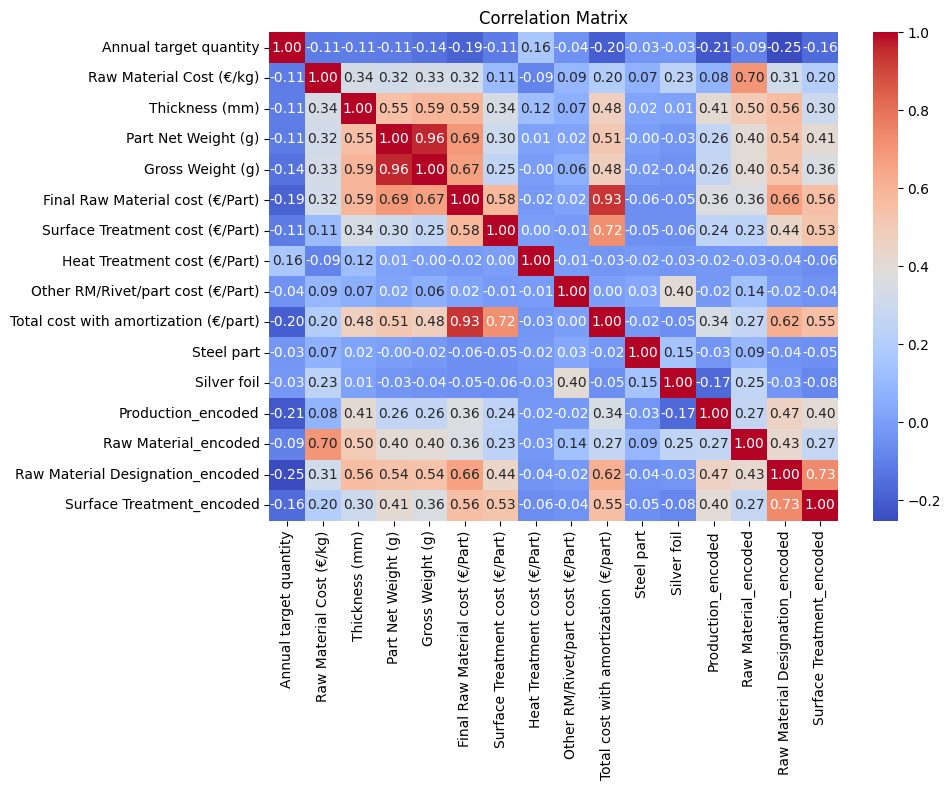

In [32]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
#Gross weight too correlated with the Net weight and more correlated with the target
df = df.drop(columns=['Gross Weight (g)'])

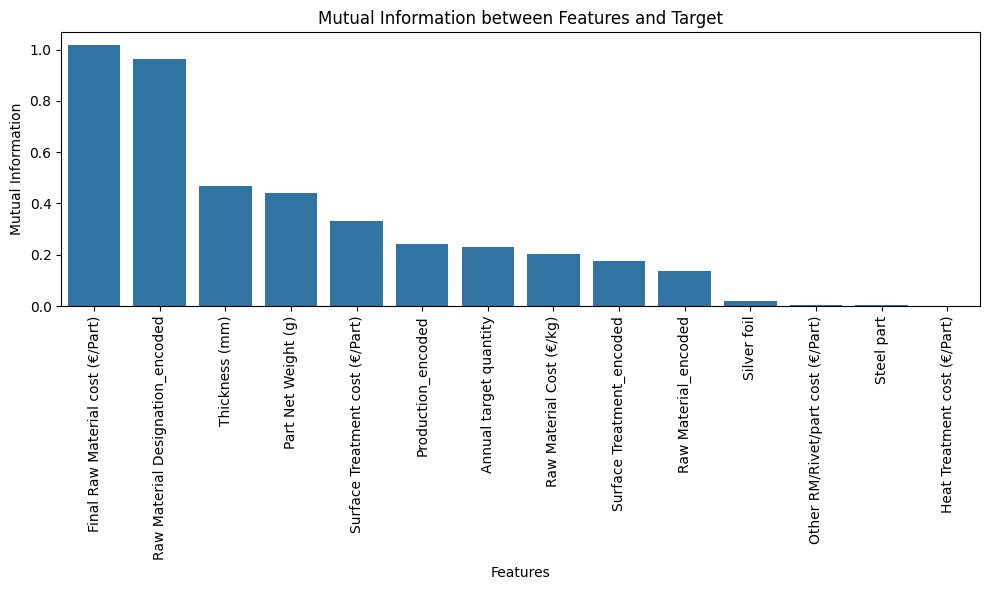

Final Raw Material cost (€/Part)     1.016297
Raw Material Designation_encoded     0.965082
Thickness (mm)                       0.466597
Part Net Weight (g)                  0.441071
Surface Treatment cost (€/Part)      0.331486
Production_encoded                   0.240680
Annual target quantity               0.231416
Raw Material Cost (€/kg)             0.202453
Surface Treatment_encoded            0.174727
Raw Material_encoded                 0.136830
Silver foil                          0.018616
Other RM/Rivet/part cost (€/Part)    0.004994
Steel part                           0.002614
Heat Treatment cost (€/Part)         0.000000
dtype: float64


In [40]:


# Ensure your DataFrame is loaded and named 'df' before running this code.
# Assuming your DataFrame 'df' and target column 'Total cost with amortization (€/part)' are defined.

target_column = 'Total cost with amortization (€/part)'
features = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)', 'Heat Treatment cost (€/Part)',
    'Other RM/Rivet/part cost (€/Part)', 'Steel part', 'Silver foil',
    'Production_encoded', 'Raw Material_encoded', 'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]

# Check if the features and target columns exist
missing_columns = []
for column in features + [target_column]:
  if column not in df.columns:
    missing_columns.append(column)

if missing_columns:
  raise ValueError(f"The following columns are missing in the DataFrame: {', '.join(missing_columns)}")

X = df[features]
y = df[target_column]

mutual_info = mutual_info_regression(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info_series.index, y=mutual_info_series.values)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between Features and Target")
plt.tight_layout()
plt.show()

print(mutual_info_series)
